<a href="https://colab.research.google.com/github/malekslokom/Bayesian-Network/blob/main/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link : https://towardsdatascience.com/applying-bayesian-networks-to-covid-19-diagnosis-73b06c3418d8

In [1]:
!pip install pyagrum pydotplus


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.1 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.core.display import display, HTML
import time
import logging

In [3]:
# Some formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 4 decimal points
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

### Functions

In [4]:
def missing(df,perc=0): 
    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ['column', 'missing count']
    missing_df['percentage']=(missing_df['missing count'])/df.shape[0]*100
    missing_df = missing_df[missing_df.percentage>perc]
    print('#columns containing missing values',len(missing_df))
    print("missing_columns=" , list(missing_df.column))
    return missing_df.sort_values(by='percentage',ascending=False)

In [5]:
def show_unique(df):
    '''Show columns that have only one value (i.e. there is no variation to exploit)'''
    counts = pd.DataFrame()
    counts['nunique'] = df.nunique()
    
    counts = counts[counts['nunique'] == 1]
    print('These columns only have one value:', list(counts.index))
    return counts

In [6]:
def fill_null(df, attribute_list, stat = 'intger', integer = -999): 
    """
    This function fills null values of selected columns with one of four different methods:
        - 'median' will fill the nulls with the median of the column. 
        - 'mean' uses the mean of the column. 
        - 'mode' uses the mode of the column. It can be used with string 
        variables, but they need to have been encoded first.
        - 'integer' fills the nulls with an integer (-999 by default).
    """
    for i in attribute_list:     
        if stat == 'median':
            df[i].fillna(df[i].median(), inplace=True) 
        elif stat == 'mean':
            df[i].fillna(df[i].mean(), inplace=True)
        elif stat == 'mode':
            df[i].fillna(df[i].mode()[0], inplace=True)     
        elif stat == 'integer':
            df[i].fillna(integer, inplace=True) 
            
    return df

In [10]:
def get_jpd_size(bn):
    return np.prod([bn.variable(node).domainSize() for node in bn.nodes()])
def get_cpts_size(bn):
    return sum([np.prod(bn.cpt(node).var_dims) for node in bn.nodes() ]) 
def compression_ratio(bn):
    return 100*(1-get_cpts_size(bn)/ get_jpd_size(bn))

In [11]:
def post(row,bn,target):
        ie = gum.LazyPropagation(bn)
        evs = row.astype(str).to_dict()
        #print(evs)
        del evs[target]
        ie.setEvidence(evs)
        ie.addTarget(target)
        return ie.posterior(target).toarray()[1]

## Wrapper class


We use a wrapper class to collect all the functions we need for our analysis (and a bit more :) )



In [12]:
# Wrapper class
class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN"""
    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood', 
               prior_weight=.5, 
               positif_label = None,
               threshold = .5,
               nb_classes = 2,               
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):
        
        
        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn
    
    
    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method, 
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}

    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
     
    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe 
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)

        
        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index)))) 
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d
        
        
    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""
        
        # create the template   
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)
                
            
        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)

        
        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()
            
        
        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())        
        del template,train

        return self
   
    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        evs = row.astype(str).to_dict()
        del evs[self.class_name]      
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()
        
       
    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        for i in range(len(test)):    
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]               
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores

   
    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():  
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happen when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores
    
    
    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]
        
        return y_true, np.where(y_scores >= self.threshold, 1, 0)
    
 
    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)

# Application to the COVID-19 dataset


dataset: https://www.kaggle.com/datasets/einsteindata4u/covid19

In [18]:
df_orig = pd.read_excel('dataset.xlsx')
df = df_orig.copy()
print('Dimensions of data:', df.shape)
df.head()

Dimensions of data: (5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.237,-0.022,-0.517,0.011,0.102,0.318,-0.951,-0.095,-0.224,-0.292,1.482,0.166,0.358,-0.625,-0.141,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619,1.198,-0.148,2.090,-0.306,0.863,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,N

In [19]:
# Rename some columns to make our lives easier
df.rename(columns= {'SARS-Cov-2 exam result': 'covid_19',
                   'Patient addmited to regular ward (1=yes, 0=no)': 'regular_ward', 
                   'Patient addmited to semi-intensive unit (1=yes, 0=no)': 'semi_intensive_care',
                   'Patient addmited to intensive care unit (1=yes, 0=no)': 'intensive_care',
                   'Influenza B, rapid test': 'Influenza B rapid test',
                   'Influenza A, rapid test': 'Influenza A rapid test'}, inplace = True)

# Dummify covid_19 var for consistency
df['covid_19'] = df['covid_19'].apply(lambda x :1 if x=='positive' else 0)

# We don't really need patient IDs, so we drop them
df.drop(columns = 'Patient ID', inplace = True)

In [20]:
df.isnull().sum()

Patient age quantile                     0
covid_19                                 0
regular_ward                             0
semi_intensive_care                      0
intensive_care                           0
                                      ... 
HCO3 (arterial blood gas analysis)    5617
pO2 (arterial blood gas analysis)     5617
Arteiral Fio2                         5624
Phosphor                              5624
ctO2 (arterial blood gas analysis)    5617
Length: 110, dtype: int64

By running our function missing on the whole dataframe, we can see that almost all columns have some missing values. In some cases, up to 99% of the values are missing, so we can safely drop these columns. We can also drop all those columns that have only one value (other than NaN). These columns do not present any variation and hence can't be use for prediction.

In [21]:
df.drop(columns = list(missing(df, perc = 95).column.values), inplace = True)
df.drop(columns = list(show_unique(df).index), inplace = True)
df.shape  

#columns containing missing values 65
missing_columns= ['Serum Glucose', 'Mycoplasma pneumoniae', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bilirubin', 'Direct Bilirubin', 'Indirect Bilirubin', 'Alkaline phosphatase', 'Ionized calcium\xa0', 'Magnesium', 'pCO2 (venous blood gas analysis)', 'Hb saturation (venous blood gas analysis)', 'Base excess (venous blood gas analysis)', 'pO2 (venous blood gas analysis)', 'Fio2 (venous blood gas analysis)', 'Total CO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)', 'HCO3 (venous blood gas analysis)', 'Rods #', 'Segmented', 'Promyelocytes', 'Metamyelocytes', 'Myelocytes', 'Myeloblasts', 'Urine - Esterase', 'Urine - Aspect', 'Urine - pH', 'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies', 'Urine - Nitrite', 'Urine - Density', 'Urine - Urobilinogen', 'Urine - Protein', 'Urine - Sugar', 'Urine - Leukocytes', 'Urine - Crystals', 'Urine - Red blood cells', 'Urine - Hyali

(5644, 44)

In [23]:
kept_cols = [i for i in df if df[i].nunique()<=4]
kept_cols.extend(['Platelets','Red blood Cells','Lymphocytes','Leukocytes'])
kept_cols,len(kept_cols)

(['covid_19',
  'regular_ward',
  'semi_intensive_care',
  'intensive_care',
  'Respiratory Syncytial Virus',
  'Influenza A',
  'Influenza B',
  'Parainfluenza 1',
  'CoronavirusNL63',
  'Rhinovirus/Enterovirus',
  'Coronavirus HKU1',
  'Parainfluenza 3',
  'Chlamydophila pneumoniae',
  'Adenovirus',
  'Parainfluenza 4',
  'Coronavirus229E',
  'CoronavirusOC43',
  'Inf A H1N1 2009',
  'Bordetella pertussis',
  'Metapneumovirus',
  'Influenza B rapid test',
  'Influenza A rapid test',
  'Strepto A',
  'Platelets',
  'Red blood Cells',
  'Lymphocytes',
  'Leukocytes'],
 27)

In [24]:
missing(df_orig)


#columns containing missing values 105
missing_columns= ['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Mycoplasma pneumoniae', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Neutrophils', 'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium', 'Influenza B, rapid test', 'Influenza A, rapid test', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bi

,column,missing count,percentage
81,Urine - Sugar,5644,100.000
89,Partial thromboplastin time (PTT),5644,100.000
27,Mycoplasma pneumoniae,5644,100.000
93,"Prothrombin time (PT), Activity",5644,100.000
99,D-Dimer,5644,100.000
...,...,...,...
24,Parainfluenza 1,4292,76.045
32,Parainfluenza 4,4292,76.045
21,Respiratory Syncytial Virus,4290,76.010
22,Influenza A,4290,76.010


In [25]:
df = df[kept_cols]
missing(df)

#columns containing missing values 23
missing_columns= ['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Influenza B rapid test', 'Influenza A rapid test', 'Strepto A', 'Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes']


,column,missing count,percentage
22,Strepto A,5312,94.118
26,Leukocytes,5042,89.334
25,Lymphocytes,5042,89.334
24,Red blood Cells,5042,89.334
23,Platelets,5042,89.334
21,Influenza A rapid test,4824,85.471
20,Influenza B rapid test,4824,85.471
16,CoronavirusOC43,4292,76.045
19,Metapneumovirus,4292,76.045
18,Bordetella pertussis,4292,76.045


**pyAgrum** cannot deal with missing values by itself, so we need to fill them before constructing the Bayesian Network. 

In [26]:
continuous_cols = [x for x in df.columns if df[x].dtypes == 'float64']
discrete_cols = [x for x in df.columns if (df[x].dtypes == 'O') | (df[x].dtypes == 'int64')]
for i in ['covid_19', 'regular_ward', 'semi_intensive_care','intensive_care']:
    discrete_cols.remove(i)  # Drop targets

df = fill_null(df, continuous_cols, stat = 'median')
df = fill_null(df, discrete_cols, stat = 'integer', integer = '-999')

Now we are ready to initialise our first BN.

In [28]:
df.to_csv('template.csv', index = False)

clf = BNEstimator(csv_template='template.csv', class_name='covid_19',
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv('train.csv',index=False)

clf.fit(train)

BNEstimator(class_name='covid_19', csv_template='template.csv',
            cut_points_percentiles=[5, 50, 95])

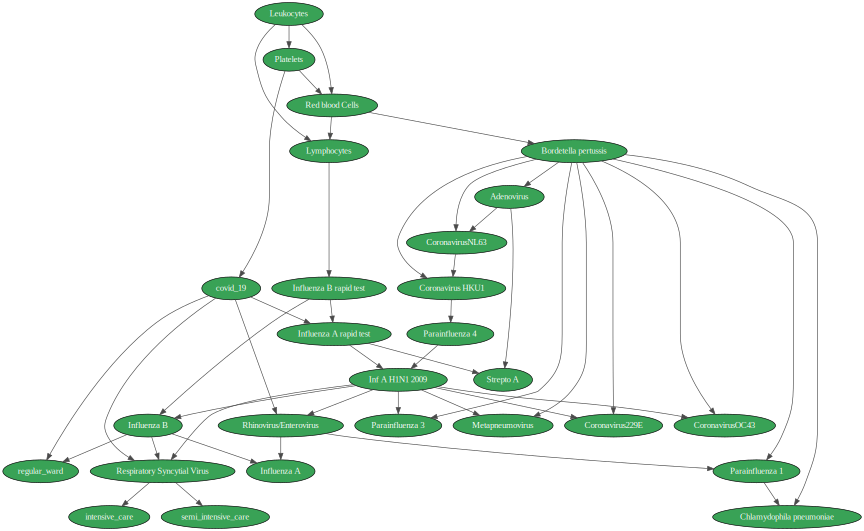

In [29]:
gnb.showBN(clf.bn,size=12,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Greens'))


The learned structure may contain some relation that doesn't make sense from a practical point of view. Here is another important feature of BN, where domain expert can intervene to encode the business knwoledge in the learning process. The framework allows us to add those constrains to the learning algorithms.Additionally, thinking in terms of prediction, we may want to enforce certain arcs from some predictive variables to our target variable(s).





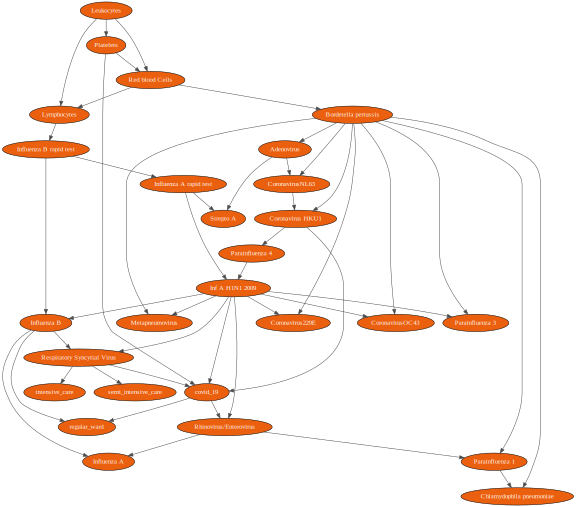

In [30]:
df.to_csv('template.csv', index = False)

clf = BNEstimator(csv_template='template.csv', class_name='covid_19',
                  tabu_arcs=[('Influenza B rapid test', 'covid_19')],
                  mandatory_arcs=[('Coronavirus HKU1','covid_19'),('Respiratory Syncytial Virus','covid_19')],
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

clf.fit(train)

gnb.showBN(clf.bn,size=8,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Oranges'))

Now we are ready to take a look at the learnt features of our BN. Let's first see the CPT for the variable regular_ward



In [34]:
clf.bn.cpt(clf.bn.idFromName('regular_ward'))


(pyAgrum.Potential<double>@0x4dc0e20) 
             ||  regular_ward     |
Influe|covid_||0        |1        |
------|------||---------|---------|
-999  |0     || 0.9975  | 0.0025  |
not_de|0     || 0.9705  | 0.0295  |
detect|0     || 0.9983  | 0.0017  |
-999  |1     || 0.9795  | 0.0205  |
not_de|1     || 0.7495  | 0.2505  |
detect|1     || 0.9286  | 0.0714  |

We can also have a look at the corresponding Markov Blanket our variables. Let's have a look at the variable covid_19.



In [35]:
gum.MarkovBlanket(clf.bn,'covid_19')


<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7fb3b5276300> >

## Prior knowledge


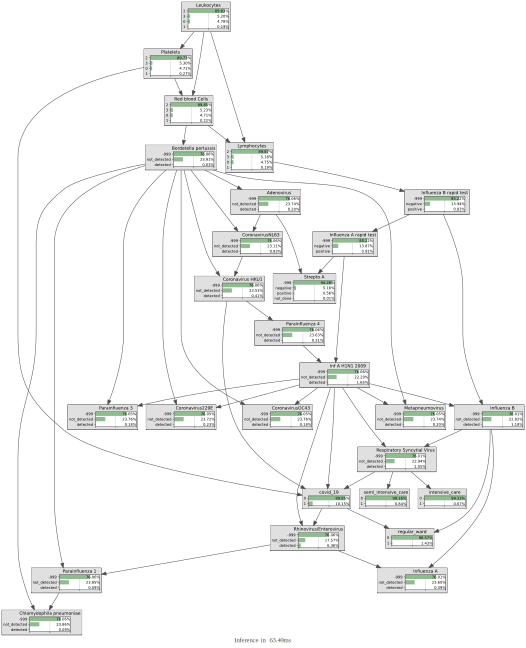

In [37]:
#  The overall probabilities for the whole network looks like this:
gnb.showInference(clf.bn,size=9)


If we are interested in (or just know) some particular variables, we can also show the posterior of our target variable conditional on these variables.



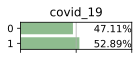

In [38]:
gnb.showPosterior(clf.bn, evs={'Platelets':'3', 'Influenza B':'detected', 'Coronavirus HKU1':'not_detected'},
                 target='covid_19')# we specify the target we want to analyse

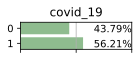

In [42]:
d_test = pd.read_csv('test.csv')
row = d_test.loc[1,:]
evs = row.astype(str).to_dict()
evidence = {'Platelets': '3',
            'Inf A H1N1 2009': 'not_detected',
            'Influenza B': 'detected',
            'Respiratory Syncytial Virus': 'detected',
            'Coronavirus HKU1': 'detected',
            'Rhinovirus/Enterovirus': 'not_detected',
            'regular_ward': 0
           }

gnb.showPosterior(clf.bn,
                 target='covid_19',
                 evs=evidence)

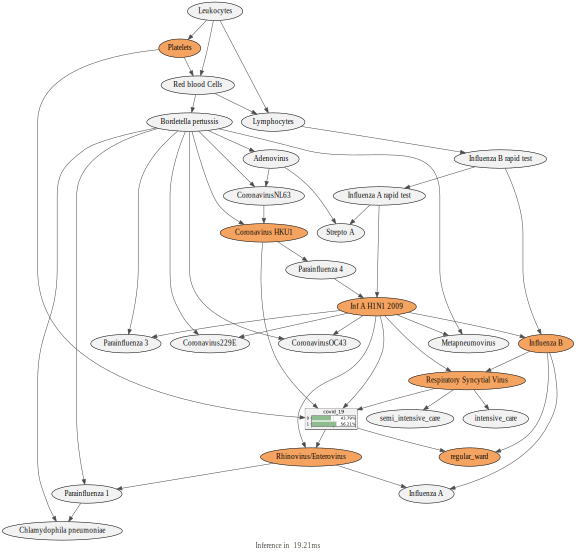

In [40]:
MB = gum.MarkovBlanket(clf.bn,'covid_19')

gnb.showInference(clf.bn, 
                  nodeColor={n:0.9 for n in clf.bn.names()},
                  evs=evidence,
                  targets={'covid_19'},
                  size=8)